**Chapter 12 – Custom Models and Training with TensorFlow**

_This notebook contains all the sample code in chapter 12._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Tensors and operations

### Tensors

In [2]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix

<tf.Tensor: id=0, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
tf.constant(42) # scalar

<tf.Tensor: id=2, shape=(), dtype=int32, numpy=42>

In [4]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: id=4, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [5]:
t.shape

TensorShape([2, 3])

In [6]:
t.dtype

tf.float32

### Indexing

In [7]:
t[:, 1:]

<tf.Tensor: id=9, shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [8]:
t[..., 1, tf.newaxis]

<tf.Tensor: id=14, shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

### Ops

In [9]:
t + 10

<tf.Tensor: id=17, shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [10]:
tf.square(t)

<tf.Tensor: id=19, shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [11]:
t @ tf.transpose(t)

<tf.Tensor: id=23, shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### Using `keras.backend`

In [12]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: id=29, shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### From/To NumPy

In [13]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: id=31, shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [14]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [15]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [16]:
tf.square(a)

<tf.Tensor: id=36, shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [17]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### Conflicting Types

In [18]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute Add as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:Add] name: add/


In [19]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute Add as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Add] name: add/


In [20]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: id=46, shape=(), dtype=float32, numpy=42.0>

### Strings

In [21]:
tf.constant(b"hello world")

<tf.Tensor: id=48, shape=(), dtype=string, numpy=b'hello world'>

In [22]:
tf.constant("café")

<tf.Tensor: id=50, shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [23]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: id=52, shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [24]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: id=64, shape=(), dtype=int32, numpy=4>

In [25]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: id=69, shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

### String arrays

In [26]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [27]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: id=72, shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [28]:
r = tf.strings.unicode_decode(p, "UTF8")
r

tf.RaggedTensor(values=tf.Tensor(
[   67    97   102   233    67   111   102   102   101   101    99    97
   102   102   232 21654 21857], shape=(17,), dtype=int32), row_splits=tf.Tensor([ 0  4 10 15 17], shape=(5,), dtype=int64))

In [29]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>


### Ragged tensors

In [30]:
print(r[1])

tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32)


In [31]:
print(r[1:3])

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [32]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
print(tf.concat([r, r2], axis=0))

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>


In [33]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71], [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [34]:
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: id=235, shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

In [35]:
r.to_tensor()

<tf.Tensor: id=301, shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]], dtype=int32)>

### Sparse tensors

In [36]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [37]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [38]:
tf.sparse.to_dense(s)

<tf.Tensor: id=310, shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [39]:
s2 = s * 2.0

In [40]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [41]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: id=315, shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [42]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [43]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] = [0,1] is out of order [Op:SparseToDense]


In [44]:
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: id=330, shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### Sets

In [45]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: id=338, shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]], dtype=int32)>

In [46]:
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: id=344, shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]], dtype=int32)>

In [47]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: id=350, shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]], dtype=int32)>

### Variables

In [48]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

In [49]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [50]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [51]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [52]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [53]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [54]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

### Tensor Arrays

In [55]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [56]:
array.read(1)

<tf.Tensor: id=391, shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [57]:
array.stack()

<tf.Tensor: id=397, shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [58]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: id=406, shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [59]:
variance

<tf.Tensor: id=407, shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

## Custom loss function

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [60]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [61]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

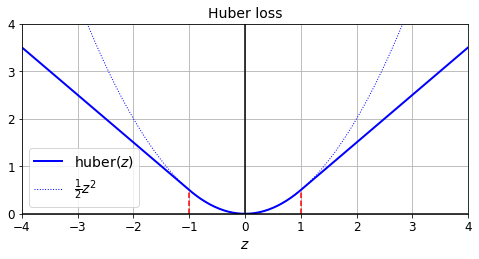

In [62]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [63]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [64]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [65]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 71us/sample - loss: 0.6223 - mae: 0.9741 - val_loss: 0.2200 - val_mae: 0.5236
Epoch 2/2
11610/11610 [==============================] - 1s 48us/sample - loss: 0.2160 - mae: 0.5158 - val_loss: 0.2038 - val_mae: 0.4928


## Saving/Loading Models with Custom Objects

In [66]:
model.save("my_model_with_a_custom_loss.h5")

In [67]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [68]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 72us/sample - loss: 0.2056 - mae: 0.4990 - val_loss: 0.1890 - val_mae: 0.4743
Epoch 2/2
11610/11610 [==============================] - 1s 48us/sample - loss: 0.2004 - mae: 0.4911 - val_loss: 0.1876 - val_mae: 0.4724


In [69]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [70]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [71]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 73us/sample - loss: 0.2212 - mae: 0.4882 - val_loss: 0.2103 - val_mae: 0.4669
Epoch 2/2
11610/11610 [==============================] - 1s 49us/sample - loss: 0.2174 - mae: 0.4836 - val_loss: 0.2020 - val_mae: 0.4647


In [72]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [73]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [74]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 74us/sample - loss: 0.2141 - mae: 0.4789 - val_loss: 0.1983 - val_mae: 0.4616
Epoch 2/2
11610/11610 [==============================] - 1s 49us/sample - loss: 0.2112 - mae: 0.4767 - val_loss: 0.2140 - val_mae: 0.4645


In [75]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [76]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [77]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [78]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 75us/sample - loss: 0.8046 - mae: 0.9679 - val_loss: 0.4891 - val_mae: 0.6449
Epoch 2/2
11610/11610 [==============================] - 1s 50us/sample - loss: 0.2531 - mae: 0.5239 - val_loss: 0.4233 - val_mae: 0.5946


In [79]:
model.save("my_model_with_a_custom_loss_class.h5")

In [80]:
#model = keras.models.load_model("my_model_with_a_custom_loss_class.h5", # TODO: check PR #25956
#                                custom_objects={"HuberLoss": HuberLoss})

In [81]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 49us/sample - loss: 0.2399 - mae: 0.5080 - val_loss: 0.3400 - val_mae: 0.5462
Epoch 2/2
11610/11610 [==============================] - 1s 50us/sample - loss: 0.2300 - mae: 0.4977 - val_loss: 0.2762 - val_mae: 0.5069


In [82]:
#model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",  # TODO: check PR #25956
#                                custom_objects={"HuberLoss": HuberLoss})

In [83]:
model.loss.threshold

2.0

## Other Custom Functions

In [84]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [85]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [86]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [87]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [88]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 77us/sample - loss: 1.9031 - mae: 0.8792 - val_loss: inf - val_mae: inf
Epoch 2/2
11610/11610 [==============================] - 1s 49us/sample - loss: 0.7626 - mae: 0.5320 - val_loss: inf - val_mae: inf


In [89]:
model.save("my_model_with_many_custom_parts.h5")

In [90]:
# TODO: 
"""
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer(0.01),
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })
"""

'\nmodel = keras.models.load_model(\n    "my_model_with_many_custom_parts.h5",\n    custom_objects={\n       "my_l1_regularizer": my_l1_regularizer(0.01),\n       "my_positive_weights": my_positive_weights,\n       "my_glorot_initializer": my_glorot_initializer,\n       "my_softplus": my_softplus,\n    })\n'

In [91]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [92]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [93]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [94]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 75us/sample - loss: 2.3877 - mae: 0.9873 - val_loss: inf - val_mae: inf
Epoch 2/2
11610/11610 [==============================] - 1s 49us/sample - loss: 0.9491 - mae: 0.5495 - val_loss: inf - val_mae: inf


In [95]:
model.save("my_model_with_many_custom_parts.h5")

In [96]:
# TODO: check https://github.com/tensorflow/tensorflow/issues/26061
"""
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })
"""

'\nmodel = keras.models.load_model(\n    "my_model_with_many_custom_parts.h5",\n    custom_objects={\n       "MyL1Regularizer": MyL1Regularizer,\n       "my_positive_weights": my_positive_weights,\n       "my_glorot_initializer": my_glorot_initializer,\n       "my_softplus": my_softplus,\n    })\n'

## Custom Metrics

In [97]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [98]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [99]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
11610/11610 [==============================] - 1s 56us/sample - loss: 2.0490 - huber_fn: 0.8245
Epoch 2/2
11610/11610 [==============================] - 0s 35us/sample - loss: 0.6203 - huber_fn: 0.2507


**Warning**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that metric = loss * mean of sample weights (plus some floating point precision error).

In [100]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [101]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
11610/11610 [==============================] - 1s 60us/sample - loss: 0.1167 - huber_fn: 0.2309
Epoch 2/2
11610/11610 [==============================] - 1s 44us/sample - loss: 0.1115 - huber_fn: 0.2218


In [102]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11666121805001702, 0.11494729649264307)

### Streaming metrics

In [103]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: id=84595, shape=(), dtype=float32, numpy=0.8>

In [104]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: id=84645, shape=(), dtype=float32, numpy=0.5>

In [105]:
precision.result()

<tf.Tensor: id=84655, shape=(), dtype=float32, numpy=0.5>

In [106]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [107]:
precision.reset_states()

Creating a streaming metric:

In [108]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [109]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: id=84709, shape=(), dtype=float32, numpy=14.0>

In [110]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: id=84745, shape=(), dtype=float32, numpy=7.0>

In [111]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [112]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Let's check that the `HuberMetric` class works well:

In [113]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [114]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [115]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
11610/11610 [==============================] - 1s 63us/sample - loss: 0.8135 - huber_metric_1: 0.8135
Epoch 2/2
11610/11610 [==============================] - 1s 46us/sample - loss: 0.2471 - huber_metric_1: 0.2471


In [116]:
model.save("my_model_with_a_custom_metric.h5")

In [117]:
#model = keras.models.load_model("my_model_with_a_custom_metric.h5",           # TODO: check PR #25956
#                                custom_objects={"huber_fn": create_huber(2.0),
#                                                "HuberMetric": HuberMetric})

In [118]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
11610/11610 [==============================] - 0s 41us/sample - loss: 0.2324 - huber_metric_1: 0.2324
Epoch 2/2
11610/11610 [==============================] - 0s 38us/sample - loss: 0.2236 - huber_metric_1: 0.2236


In [119]:
model.metrics[0].threshold

2.0

Looks like it works fine! More simply, we could have created the class like this:

In [120]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

This class handles shapes better, and it also supports sample weights.

In [121]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [122]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [123]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
11610/11610 [==============================] - 1s 84us/sample - loss: 0.4076 - HuberMetric: 0.8146
Epoch 2/2
11610/11610 [==============================] - 1s 52us/sample - loss: 0.1188 - HuberMetric: 0.2374


In [124]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.407584022901933, 0.4075840845370592)

In [125]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [126]:
#model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",        # TODO: check PR #25956
#                                custom_objects={"HuberMetric": HuberMetric})

In [127]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
11610/11610 [==============================] - 1s 45us/sample - loss: 0.2269 - HuberMetric: 0.2269
Epoch 2/2
11610/11610 [==============================] - 0s 41us/sample - loss: 0.2193 - HuberMetric: 0.2193


In [128]:
model.metrics[0].threshold

2.0

## Custom Layers

In [129]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [130]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: id=110600, shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000):

In [131]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/5
11610/11610 [==============================] - 1s 81us/sample - loss: 17455295763.6862 - val_loss: 5.2690
Epoch 2/5
11610/11610 [==============================] - 1s 50us/sample - loss: 34.5006 - val_loss: 1.6420
Epoch 3/5
11610/11610 [==============================] - 1s 50us/sample - loss: 2.1489 - val_loss: 1.1421
Epoch 4/5
11610/11610 [==============================] - 1s 49us/sample - loss: 1.1264 - val_loss: 0.7558
Epoch 5/5
5160/5160 [==============================] - 0s 19us/sample - loss: 29118.6526


29118.652586295255

In [132]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [133]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [134]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 70us/sample - loss: 1.4813 - val_loss: 22.7766
Epoch 2/2
5160/5160 [==============================] - 0s 18us/sample - loss: 0.5322


0.5321827204652535

In [135]:
model.save("my_model_with_a_custom_layer.h5")

In [136]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [137]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [138]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

Let's create a layer with a different behavior during training and testing:

In [139]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training is None:
            training = keras.backend.learning_phase()
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [140]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 70us/sample - loss: 0.5817 - val_loss: 12.9048
Epoch 2/2
5160/5160 [==============================] - 0s 17us/sample - loss: 0.4285


0.4284568049648935

## Custom Models

In [141]:
X_new_scaled = X_test_scaled

In [142]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.n_layers = n_layers                                     # not shown in the book
        self.n_neurons = n_neurons                                   # not shown
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z
    
    def get_config(self):                                            # not shown
        base_config = super().get_config()                           # not shown
        return {**base_config,                                       # not shown
                "n_layers": self.n_layers, "n_neurons": n_neurons}   # not shown

In [143]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim                                 # not shown in the book
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

    def get_config(self):                                            # not shown
        base_config = super().get_config()                           # not shown
        return {**base_config,                                       # not shown
                "output_dim": self.output_dim}                       # not shown

In [144]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
11610/11610 [==============================] - 1s 118us/sample - loss: 2.7279
Epoch 2/5
11610/11610 [==============================] - 1s 69us/sample - loss: 1.0324
Epoch 3/5
11610/11610 [==============================] - 1s 66us/sample - loss: 1.0542
Epoch 4/5
11610/11610 [==============================] - 1s 64us/sample - loss: 0.5402
Epoch 5/5
5160/5160 [==============================] - 0s 34us/sample - loss: 1.2116


In [145]:
#TODO: check that persistence ends up working in TF2
#model.save("my_custom_model.h5")
#model = keras.models.load_model("my_custom_model.h5",
#                                custom_objects={
#                                    "ResidualBlock": ResidualBlock,
#                                    "ResidualRegressor": ResidualRegressor
#                                })

We could have defined the model using the sequential API instead:

In [146]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [147]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
11610/11610 [==============================] - 2s 163us/sample - loss: 1.5833
Epoch 2/5
11610/11610 [==============================] - 1s 97us/sample - loss: 0.6670
Epoch 3/5
11610/11610 [==============================] - 1s 96us/sample - loss: 2.2517
Epoch 4/5
11610/11610 [==============================] - 1s 94us/sample - loss: 0.5019
Epoch 5/5
5160/5160 [==============================] - 0s 28us/sample - loss: 1.0046


## Losses and Metrics Based on Model Internals

TODO: check https://github.com/tensorflow/tensorflow/issues/26260
```python
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    @tf.function
    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * reconstruction_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

model = ReconstructingRegressor(1)
model.build(tf.TensorShape([None, 8]))       # <= Fails if this line is removed
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X, y, epochs=2)
```

In [148]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        return self.out(Z)

In [149]:
model = ReconstructingRegressor(1)
model.build(tf.TensorShape([None, 8])) # TODO: check https://github.com/tensorflow/tensorflow/issues/26274
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
11610/11610 [==============================] - 2s 141us/sample - loss: 0.6859
Epoch 2/2
11610/11610 [==============================] - 1s 83us/sample - loss: 0.4133


## Computing Gradients Using Autodiff

In [150]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [151]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [152]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [153]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [154]:
gradients

[<tf.Tensor: id=180500, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=180471, shape=(), dtype=float32, numpy=10.0>]

In [155]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

GradientTape.gradient can only be called once on non-persistent tapes.


In [156]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [157]:
dz_dw1, dz_dw2

(<tf.Tensor: id=180588, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=180591, shape=(), dtype=float32, numpy=10.0>)

In [158]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [159]:
gradients

[None, None]

In [160]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [161]:
gradients

[<tf.Tensor: id=180671, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=180642, shape=(), dtype=float32, numpy=10.0>]

In [162]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: id=180806, shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: id=180807, shape=(), dtype=float32, numpy=30.0>]

In [163]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [164]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [165]:
jacobians

[<tf.Tensor: id=180993, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=180964, shape=(), dtype=float32, numpy=10.0>]

In [166]:
hessians

[[<tf.Tensor: id=181017, shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: id=181034, shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: id=181039, shape=(), dtype=float32, numpy=2.0>, None]]

In [167]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: id=181073, shape=(), dtype=float32, numpy=30.0>, None]

In [168]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: id=181103, shape=(), dtype=float32, numpy=nan>]

In [169]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: id=181109, shape=(), dtype=float32, numpy=30.0>

In [170]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: id=181136, shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [171]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [172]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [173]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: id=181154, shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: id=181178, shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

# Computing Gradients Using Autodiff

In [174]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [175]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [176]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [177]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


A fancier version with a progress bar:

In [178]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [179]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [180]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [181]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [182]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [183]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - mean: 1.5850 - mean_absolute_error: 0.57446
Epoch 2/5
11610/11610 [==============================] - mean: 0.7521 - mean_absolute_error: 0.5266
Epoch 3/5
11610/11610 [==============================] - mean: 0.7095 - mean_absolute_error: 0.5347
Epoch 4/5
11610/11610 [==============================] - mean: 0.6629 - mean_absolute_error: 0.5236
Epoch 5/5
11610/11610 [==============================] - mean: 0.6421 - mean_absolute_error: 0.5150


In [184]:
try:
    from tqdm import tnrange
    from collections import OrderedDict
    with tnrange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with tnrange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

## TensorFlow Functions

In [185]:
def cube(x):
    return x ** 3

In [186]:
cube(2)

8

In [187]:
cube(tf.constant(2.0))

<tf.Tensor: id=1508933, shape=(), dtype=float32, numpy=8.0>

In [188]:
tf_cube = tf.function(cube)
tf_cube

In [189]:
tf_cube(2)

<tf.Tensor: id=1508940, shape=(), dtype=int32, numpy=8>

In [190]:
tf_cube(tf.constant(2.0))

<tf.Tensor: id=1508950, shape=(), dtype=float32, numpy=8.0>

### TF Functions and Concrete Functions

In [191]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [192]:
concrete_function(tf.constant(2.0))

<tf.Tensor: id=1508955, shape=(), dtype=float32, numpy=8.0>

In [193]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### Exploring Function Definitions and Graphs

In [194]:
concrete_function.graph

In [195]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [196]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [197]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [198]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [199]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [200]:
concrete_function.function_def.signature

name: "__inference_cube_1508949"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### How TF Functions Trace Python Functions to Extract Their Computation Graphs

In [201]:
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [202]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


In [203]:
result

<tf.Tensor: id=1508968, shape=(), dtype=float32, numpy=8.0>

In [204]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]])) # New shape: trace!
result = tf_cube(tf.constant([[3., 4.], [5., 6.]])) # New shape: trace!
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]])) # no trace

print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(None, 2), dtype=float32)


It is also possible to specify a particular input signature:

In [205]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)
    return images[:, ::2, ::2] # drop half the rows and columns

In [206]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # Traces the function.
preprocessed_images = shrink(img_batch_2) # Reuses the same concrete function.

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [207]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # rejects unexpected types or shapes
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature: inputs ((<tf.Tensor: id=1509032, shape=(2, 2, 2), dtype=float32, numpy=
array([[[0.888957  , 0.60685956],
        [0.01694834, 0.01444435]],

       [[0.7288147 , 0.3239665 ],
        [0.45528448, 0.43155968]]], dtype=float32)>,)), input_signature ((TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None),))


### Using Autograph To Capture Control Flow

A "static" `for` loop using `range()`:

In [208]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [209]:
add_10(tf.constant(5))

<tf.Tensor: id=1509061, shape=(), dtype=int32, numpy=15>

In [210]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=Add>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=Add>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=Add>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=Add>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=Add>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=Add>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=Add>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=Add>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=Add>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=Add>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" loop using `tf.while_loop()`:

In [211]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [212]:
add_10(tf.constant(5))

<tf.Tensor: id=1509107, shape=(), dtype=int32, numpy=15>

In [213]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=While>,
 <tf.Operation 'while/Identity' type=Identity>,
 <tf.Operation 'while/Identity_1' type=Identity>,
 <tf.Operation 'while/Identity_2' type=Identity>,
 <tf.Operation 'while/Identity_3' type=Identity>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" `for` loop using `tf.range()` (captured by autograph):

In [214]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [215]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=While>,
 <tf.Operation 'while/Identity' type=Identity>,
 <tf.Operation 'while/Identity_1' type=Identity>,
 <tf.Operation 'while/Identity_2' type=Identity>,
 <tf.Operation 'while/Identity_3' type=Identity>,
 <tf.Operation 'while/Identity_4' type=Identity>,
 <tf.Operation 'Identity' type=Identity>]

### Handling Variables and Other Resources in TF Functions

In [216]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

In [217]:
increment(counter)
increment(counter)

<tf.Tensor: id=1509189, shape=(), dtype=int32, numpy=2>

In [218]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [219]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [220]:
increment()
increment()

<tf.Tensor: id=1509207, shape=(), dtype=int32, numpy=2>

In [221]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [222]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [223]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: id=1509225, shape=(), dtype=int32, numpy=2>

In [224]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

tf.autograph.to_code(add_10.python_function, experimental_optional_features=None)
# TODO: experimental_optional_features is needed to have the same behavior as @tf.function,
#       check that this is not needed when TF2 is released

"from __future__ import print_function\n\ndef tf__add_10(x):\n  do_return = False\n  retval_ = None\n\n  def loop_body(loop_vars, x_1):\n    i = loop_vars\n    x_1 += 1\n    return x_1,\n  x, = ag__.for_stmt(ag__.converted_call('range', tf, ag__.ConversionOptions(recursive=True, verbose=0, strip_decorators=(ag__.convert, ag__.do_not_convert, ag__.converted_call), force_conversion=False, optional_features=(), internal_convert_user_code=True), (10,), {}), None, loop_body, (x,))\n  do_return = True\n  retval_ = x\n  return retval_\n\n\n\ntf__add_10.autograph_info__ = {}\n"

In [225]:
def display_tf_code(func, experimental_optional_features=None):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func, experimental_optional_features=experimental_optional_features)
    display(Markdown('```python\n{}\n```'.format(code)))

In [226]:
display_tf_code(add_10)

```python
from __future__ import print_function

def tf__add_10(x):
  do_return = False
  retval_ = None

  def loop_body(loop_vars, x_1):
    i = loop_vars
    x_1 += 1
    return x_1,
  x, = ag__.for_stmt(ag__.converted_call('range', tf, ag__.ConversionOptions(recursive=True, verbose=0, strip_decorators=(ag__.convert, ag__.do_not_convert, ag__.converted_call), force_conversion=False, optional_features=(), internal_convert_user_code=True), (10,), {}), None, loop_body, (x,))
  do_return = True
  retval_ = x
  return retval_



tf__add_10.autograph_info__ = {}

```

## Using TF Functions with tf.keras (or Not)

By default, tf.keras will automatically convert your custom code into TF Functions, no need to use
`tf.function()`:

In [227]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [228]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [229]:
# Custom layer
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [230]:
# Custom model
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [231]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [232]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing metric my_mae()
Tracing metric my_mae()
Tracing loss my_mse()
Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 77us/sample - loss: 1.4017 - my_mae: 0.8108 - val_loss: 0.4857 - val_my_mae: 0.4775
Epoch 2/2
5160/5160 [==============================] - 0s 15us/sample - loss: 0.4326 - my_mae: 0.4597


[0.43256516364193703, 0.45965773]

You can turn this off by creating the model with `dynamic=True` (or calling `super().__init__(dynamic=True, **kwargs)` in the model's constructor):

In [233]:
model = MyModel(dynamic=True)

In [234]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

Not the custom code will be called at each iteration. Let's fit, validate and evaluate with tiny datasets to avoid getting too much output:

In [235]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.544255495071411, 2.0656278]

Alternatively, you can compile a model with `run_eagerly=True`:

In [236]:
model = MyModel()

In [237]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [238]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.633018493652344, 2.0630658]

## Custom Optimizers

Defining custom optimizers is not very common, but in case you are one of the happy few who gets to write one, here is an example:

In [239]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [240]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
11610/11610 [==============================] - 0s 33us/sample - loss: 4.6747
Epoch 2/5
11610/11610 [==============================] - 0s 26us/sample - loss: 1.4888
Epoch 3/5
11610/11610 [==============================] - 0s 25us/sample - loss: 0.8565
Epoch 4/5
11610/11610 [==============================] - 0s 25us/sample - loss: 0.7086
Epoch 5/5
11610/11610 [==============================] - 0s 26us/sample - loss: 0.6652
